# B sensitivity test
Here we check how the B parameter of Holland (1980) changes across all the different TCs that we have in the dataset. To do so, we first sort the TCs by category. Second, we define a piecewise B: B1 for the inner-core, B2 for the region right after the eyewall and B3 for the outer region. Then, we check how B1, B2 and B3 are modified as a function of the generak shape of the TC (asymmetry, presence of certain rainbands, etc...). 

The radii R1 and R2 corresponding to the 3 pieces on which the profile is defined are computed as Rmax for R1 and then a cubic fraction of Rmax for R2.

When we allowed A to vary, the piecewise fitting had a larger RMSE than the Holland fitting, and the piecewise profile was really bad for a significant part of the TCs. It's even worse when A is fixed. 

Clearly, the way we define Rfit will be crucial. Maybe we should also test with only 2 pieces (at Rmax, or Rmerge from Chavas). We can also use Rmerge from Chavas as R2. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import griddata
from scipy.optimize import curve_fit

import glob

import functions as f

In [2]:
### PATHS
dir_path = '/home/arthur/data/cyclobs/rotated_files/'
all_data = glob.glob(dir_path + "*.nc")
print("Total number of files:", len(all_data))
# Categories: 'dep', 'storm', 'cat-1', 'cat-2', 'cat-3', 'cat-4', 'cat-5'
# Nb of TCs:    1,      139,     88,      44,      57,      37,      19

### PARAMS
PARAMS = {
    'print_params_values': False
    }

Total number of files: 385


In [3]:
### INITIALIZE DATA STRUCTURE
INI = {           # Initial values
    'Holland':   [], # Lat, pn, pc, Vmin, Rmax, Vmax
    'B_sens':    [], # rho, Lat, R1, V1, pn, pc, Vmin, A, B
    'Chavas':    []  # Vmax, Rfit, Vfit, fcor, Cdvary, Cd, w_cool, CkCdvary, CkCd, eye_adj, alpha_eye
    } 
FIT = {           # Fit values
    'Holland':   [], # Lat, pn, pc, Vmin, Rmax, Vmax
    'B_sens':    [], # R1, pn, pc, Vmin, A, B0, B1
    'Chavas':    []  # rr, VV, rmax, r0, rmerge, Vmerge
    } 

1 =>     /home/arthur/data/cyclobs/rotated_files/s1b-ew-owi-cm-20181222t002236-20181222t002440-000003-01A498_ll_gd_rotated.nc
2 =>     /home/arthur/data/cyclobs/rotated_files/rs2--owi-cm-20141105t203222-20141105t203338-00003-E41DA_ll_gd_rotated.nc
3 =>     /home/arthur/data/cyclobs/rotated_files/rs2--owi-cm-20161008t102403-20161008t102520-00003-E08D0_ll_gd_rotated.nc


/home/arthur/scripts/windProfiles/symmetric/functions.py:586: RuntimeWarning: Mean of empty slice
  spdm   = np.nanmean(spd, axis=0)


4 =>     /home/arthur/data/cyclobs/rotated_files/s1a-ew-owi-cm-20181110t020115-20181110t020319-000003-02B0A7_ll_gd_rotated.nc
5 =>     /home/arthur/data/cyclobs/rotated_files/s1a-ew-owi-cm-20200725t034755-20200725t035002-000003-03E50E_ll_gd_rotated.nc
6 =>     /home/arthur/data/cyclobs/rotated_files/s1b-iw-owi-cm-20201031t212858-20201031t213128-000003-02DBDB_ll_gd_rotated.nc
7 =>     /home/arthur/data/cyclobs/rotated_files/rs2--owi-cm-20150515t083749-20150515t083905-00003-E0BD9_ll_gd_rotated.nc
8 =>     /home/arthur/data/cyclobs/rotated_files/s1a-iw-owi-cm-20180823t043704-20180823t043913-000003-028AD1_ll_gd_rotated.nc


/home/arthur/scripts/windProfiles/symmetric/functions.py:586: RuntimeWarning: Mean of empty slice
  spdm   = np.nanmean(spd, axis=0)


9 =>     /home/arthur/data/cyclobs/rotated_files/s1a-iw-owi-cm-20200516t232006-20200516t232121-000003-03C684_ll_gd_rotated.nc


/home/arthur/scripts/windProfiles/symmetric/functions.py:586: RuntimeWarning: Mean of empty slice
  spdm   = np.nanmean(spd, axis=0)


RuntimeError: Optimal parameters not found: The maximum number of function evaluations is exceeded.

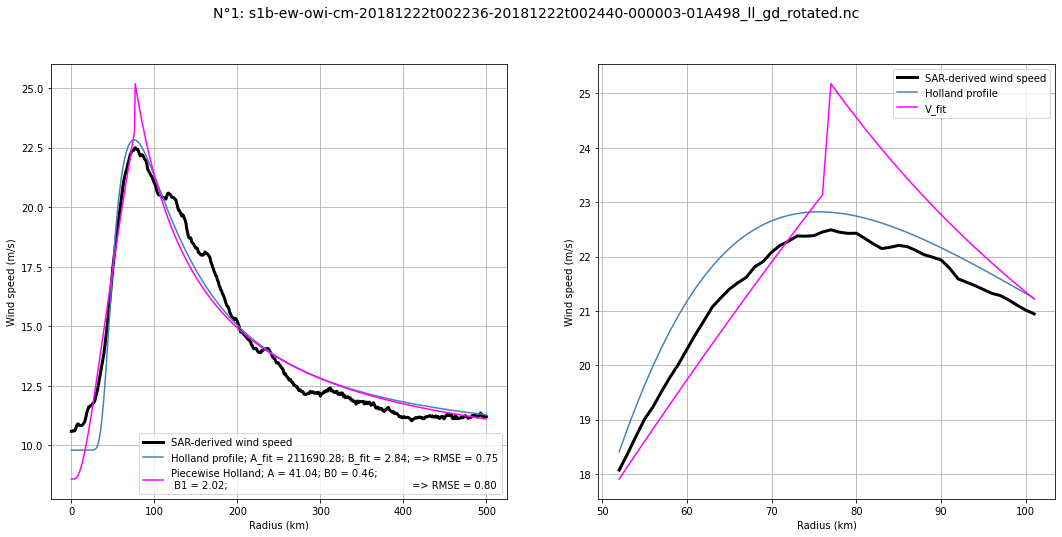

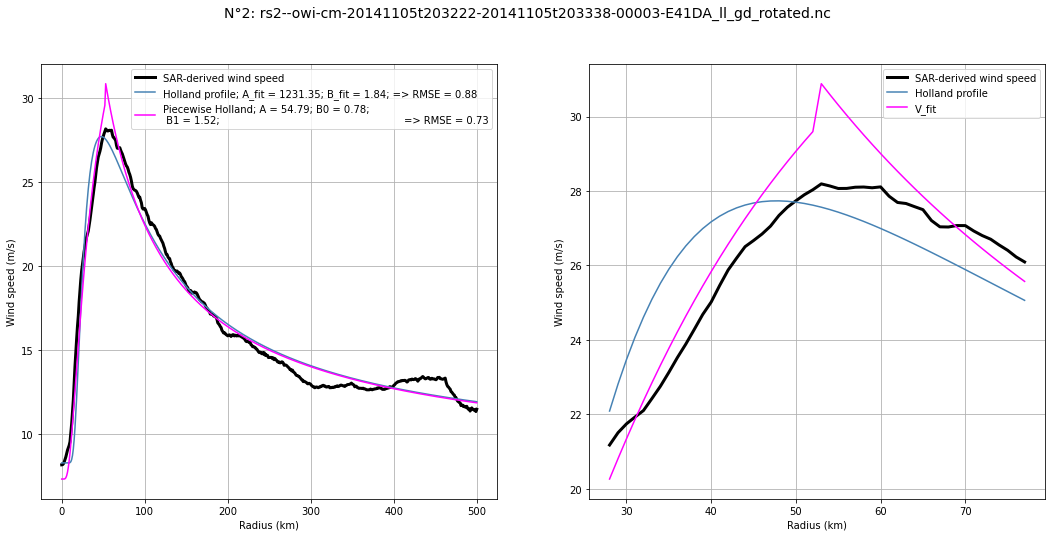

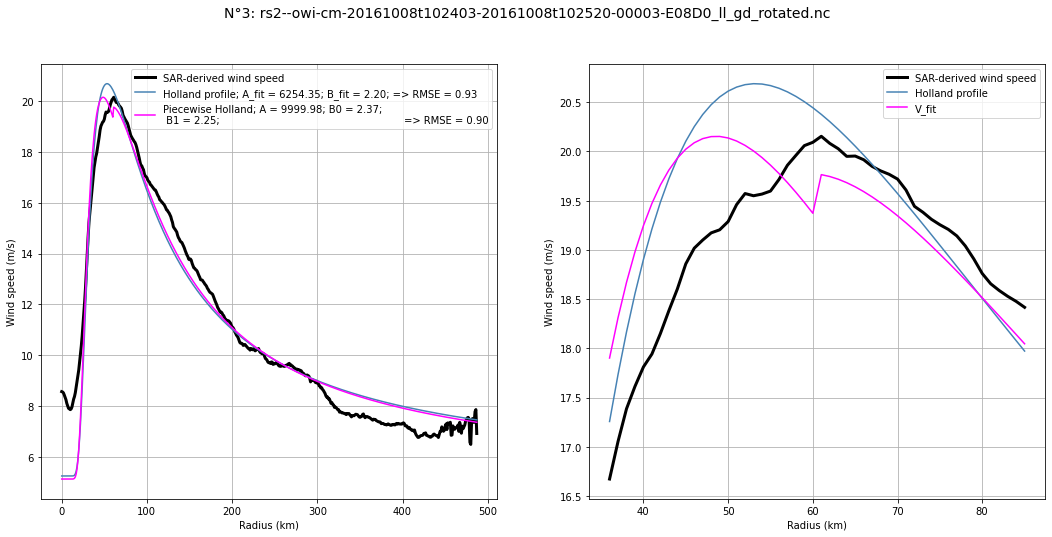

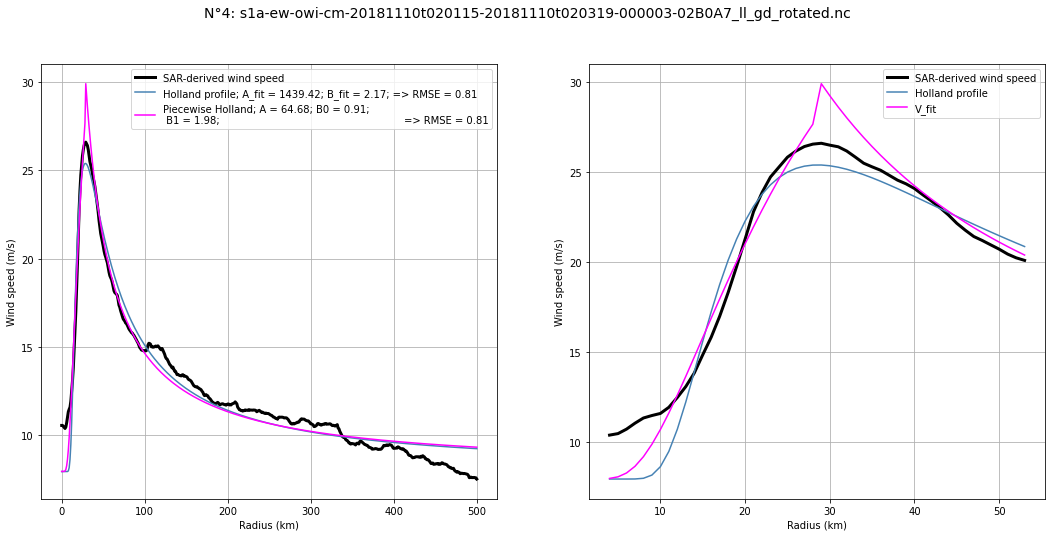

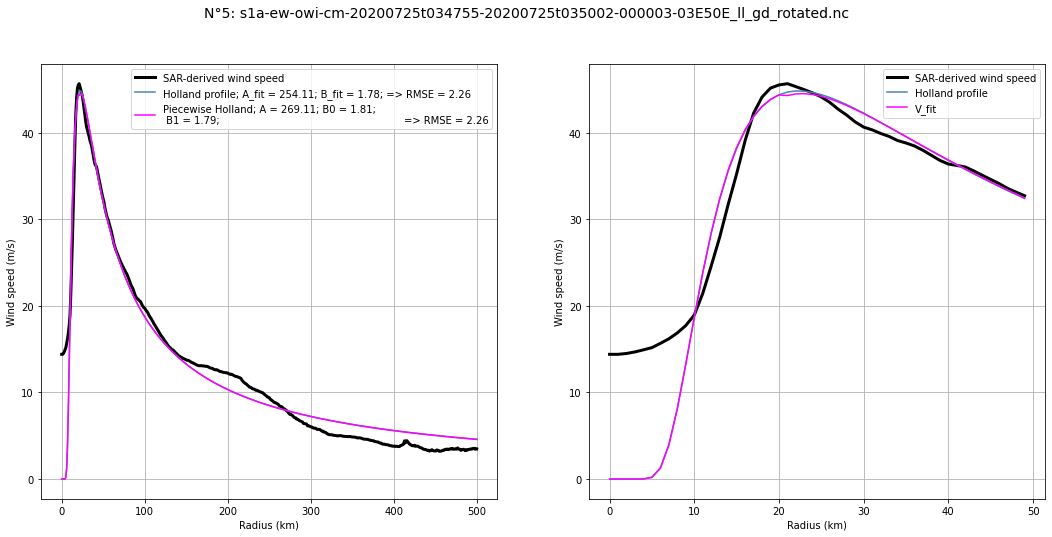

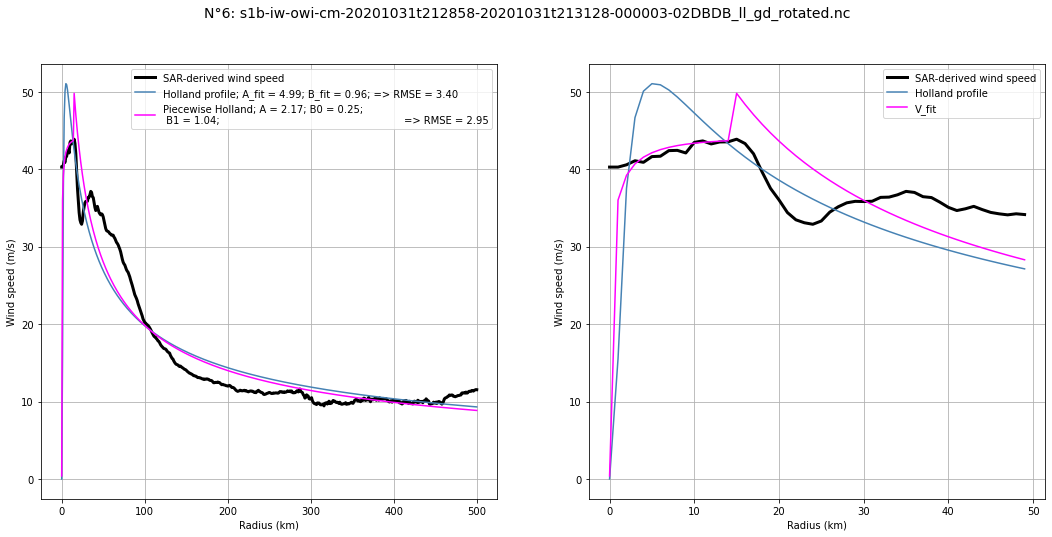

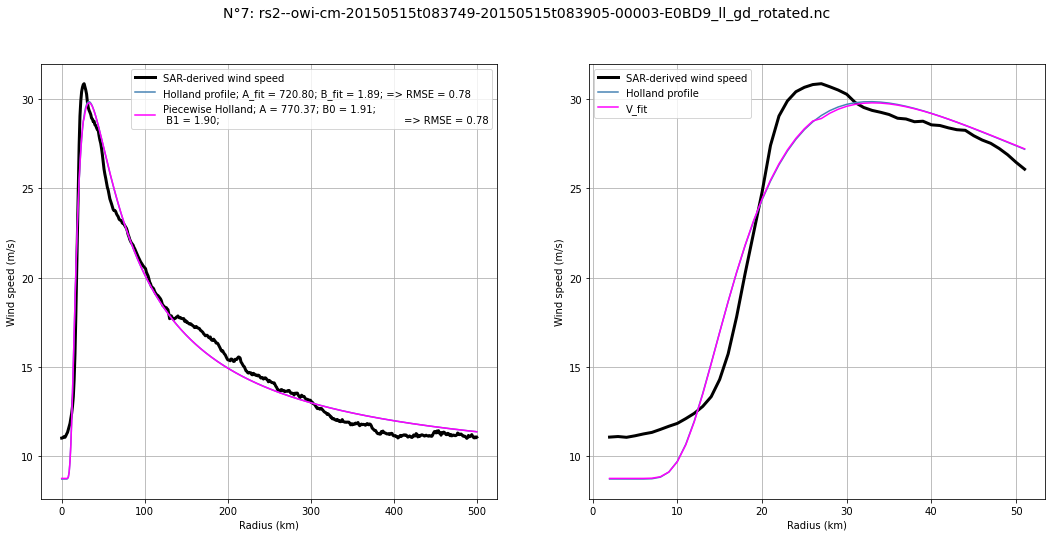

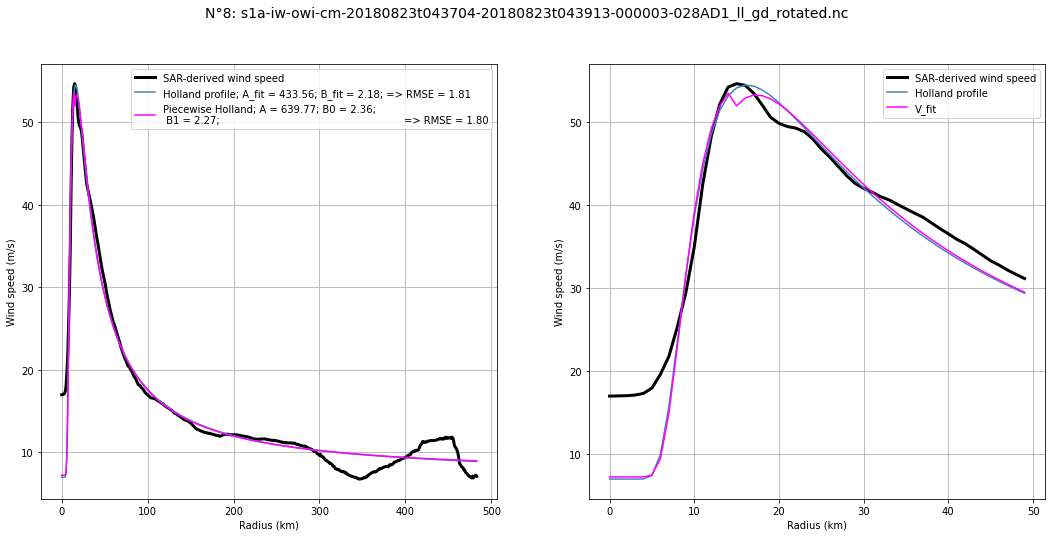

In [4]:
### SORT THE TCs BY CATEGORY
i = 0 
for file in all_data[30:50]:
    i += 1
    print(i, "=>    ", file)
    # Open file and compute mean wind speed
    ds   = xr.open_dataset(file)
    # print(ds['current_category'])
    spdm    = f.compute_mean_wind_spd(ds, 501)
    
    # Initialize and fit profile
    r, spdm       = f.initialize_radius(spdm)
    
    INI['B_sens'] = f.initialize_twoB_sensitivity_experiment(spdm, power_law=3, rho=1.15, Lat=ds['lat_ref'], pn=1004 * 100., pc=967 * 100., print_values=PARAMS['print_params_values'])
    INI['Holland']= f.initialize_holland(spdm, Lat=np.float64(ds['lat_ref']), pn=1005, pc=950, print_values=PARAMS['print_params_values'])
    
    FIT['B_sens'] = f.fit_twoB_sensitivity_experiment(r, spdm, *INI['B_sens'], print_values=PARAMS['print_params_values'])
    FIT['Holland']= f.fit_holland(r, spdm, *INI['Holland'],                 print_values=PARAMS['print_params_values'])
    
        
    f.plot_twoB_sensitivity_experiment(i, file, r, spdm, INI, FIT)
    
   
    